In [ ]:
import os
import json
import math
import numpy as np
import pandas as pd
import random
from bokeh.io import output_file, show , output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,  LabelSet
from bokeh.palettes import Viridis256,all_palettes,BrBG, PiYG, RdGy, RdYlGn, YlGnBu, PuBuGn, Colorblind, Bokeh,Category20,Accent
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from PIL import Image
from tqdm.auto import tqdm, trange
import glob
import re
from pynvml import *
from datetime import datetime
from fancyimpute import IterativeImputer

import torchvision,torch
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F
from torchvision import models
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from torchsummary import summary
import adabound
import scikitplot as skplt

# Class Functions

In [3]:
def get_class_names(y_data):
    y_class_names = []
    for i in range(len(y_data)):
        if(y_data[i]==0):
            y_class_names.append("Alive")
        elif (y_data[i]==1):
            y_class_names.append("Dead")
    return y_class_names

In [4]:
def print_multi_confusion_matrix(actual_class, pred_class,target_names):
    df_array  = confusion_matrix(actual_class, pred_class)
    df_cm = pd.DataFrame(df_array, index = [i for i in ["T_" + x for x in target_names]],
                      columns = [i for i in ["P_" + x for x in target_names]])
    plt.figure(figsize = (7,7))
    plt.title("Confusion Matrix")
    plt.xlabel('Target Lvef')
    plt.ylabel('Predicted Lvef')
    sn.heatmap(df_cm, annot=True,fmt=".1f")
    sn.set(font_scale=1) 
    print(classification_report(actual_class , pred_class, target_names=target_names))

In [5]:
def plot_roc_multi(y_true, y_probas,class_labels, title='ROC Curves',
                   plot_micro=True, plot_macro=True, classes_to_plot=None,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium"):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = np.array(class_labels)
    probas = y_probas

    if classes_to_plot is None:
        classes_to_plot = classes

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    fpr_dict = dict()
    tpr_dict = dict()

    indices_to_plot = np.in1d(classes, classes_to_plot)
    for i, to_plot in enumerate(indices_to_plot):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true, probas[:, i],
                                                pos_label=classes[i])
        if to_plot:
            roc_auc = auc(fpr_dict[i], tpr_dict[i])
            color = plt.cm.get_cmap(cmap)(float(i) / len(classes))
            ax.plot(fpr_dict[i], tpr_dict[i], lw=2, color=color,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                          ''.format(classes[i], roc_auc))

    if plot_micro:
        binarized_y_true = label_binarize(y_true, classes=classes)
        if len(classes) == 2:
            binarized_y_true = np.hstack(
                (1 - binarized_y_true, binarized_y_true))
        fpr, tpr, _ = roc_curve(binarized_y_true.ravel(), probas.ravel())
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr,
                label='micro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='deeppink', linestyle=':', linewidth=4)
    micro_auc = roc_auc
    
    if plot_macro:
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr_dict[x] for x in range(len(classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])

        # Finally average it and compute AUC
        mean_tpr /= len(classes)
        roc_auc = auc(all_fpr, mean_tpr)

        ax.plot(all_fpr, mean_tpr,
                label='macro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='navy', linestyle=':', linewidth=4)
    macro_auc = roc_auc

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=text_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='lower right', fontsize=text_fontsize)
    return micro_auc,macro_auc

In [6]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [9]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

In [10]:
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
 
    return (b_0, b_1)

In [11]:
def plot_regression_line(x, y, b, x_title, y_title):
    # plotting the actual points as scatter plot
    plt.scatter(x, y, color = "green",
               marker = "o", s = 30)
 
    # predicted response vector
    y_pred = b[0] + b[1]*x
 
    # plotting the regression line
    plt.plot(x, y_pred, color = "red")
 
    # putting labels
    plt.title("Scatter plot for regression")
    plt.xlabel(x_title)
    plt.ylabel(y_title)
 
    # function to show plot
    plt.show()

In [12]:
def loadvideo(filename: str) -> np.ndarray:
    """Loads a video from a file.
    Args:
        filename (str): filename of video
    Returns:
        A np.ndarray with dimensions (channels=3, frames, height, width). The
        values will be uint8's ranging from 0 to 255.
    Raises:
        FileNotFoundError: Could not find `filename`
        ValueError: An error occurred while reading the video
    """

    if not os.path.exists(filename):
        raise FileNotFoundError(filename)
    capture = cv2.VideoCapture(filename)

    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    v = np.zeros((frame_count, frame_height, frame_width, 3), np.uint8)

    for count in range(frame_count):
        ret, frame = capture.read()
        if not ret:
            raise ValueError("Failed to load frame #{} of {}.".format(count, filename))

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        v[count, :, :] = frame

    v = v.transpose((3, 0, 1, 2))
    

    return v

In [13]:
def store_frames(frames, path2store):
    for ii, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        path2img = os.path.join(path2store, "frame"+str(ii)+".jpg")
        cv2.imwrite(path2img, frame) 

In [14]:
def get_frames(filename, n_frames= 1):
    frames = []
    v_cap = cv2.VideoCapture(filename) #open the video file
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))  #passing the respective property name into the .get method of the video pointer will allow us to obtain the total number of frames in the video 
    frame_list= np.linspace(0, v_len-1, n_frames, dtype=np.int16)
    all_frames = []
    for fn in range(v_len):
        success, frame = v_cap.read() #reades every frame if the frames are over it will go to the next video
        if success is False:
            continue
        all_frames.append(frame)
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release()
    return all_frames, frames

In [15]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [16]:
def bland_altman_plot(data1, data2, title = "LVEF", *args, **kwargs, ):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title("Bland–Altman plot")
    plt.xlabel("Average of the 2 values")
    plt.ylabel("Difference between predicted and actual " + title +  "values")

In [17]:
def loss_batch(loss_func, output, target, opt=None): 
     
    loss = loss_func(output.to(device), target.to(device))
    with torch.no_grad():
        metric = 0
        for i in range(len(target)):
            if(int(torch.argmax(output[i]).item())==int(target[i].item())):
                metric+=1      
                
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric

In [18]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl)
    total_data = len(dataset_dl.dataset)
    count=0;
    for xb, yb in tqdm(dataset_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        
        
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        count+=1;
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break
    
    loss=running_loss/float(len_data)
    
    metric=running_metric/float(total_data)
    
    return loss, metric

In [19]:
import copy
def train_val(model, params, take_loss = True):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    best_metric=float('inf') 
    
    for epoch in range(num_epochs):
            
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if(take_loss):
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
                torch.save(model.state_dict(), path2weights)
                print("Copied best model weights!")
            
            lr_scheduler.step(val_loss)
            if current_lr != get_lr(opt):
                print("Loading best model weights!")
                model.load_state_dict(best_model_wts) 

            
        print("train loss: %.6f, Accuracy: %.2f" %(train_loss,train_metric))
        print("val loss: %.6f, Accuracy: %.2f" %(val_loss,val_metric))
        print("-"*10) 
        

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [20]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1) #[1, 16, 3, 224, 224] - >  [1, 3, 16, 224, 224]
    labels_tensor = torch.stack(label_batch)

    return imgs_tensor, labels_tensor

In [21]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [22]:
def get_auc_curve(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    return fpr,tpr,threshold

def plot_auc_curve(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
def get_best_threshold(y_true, y_pred, thresholds):
    best_threshold = 0.5
    best_youden_index = 0
    for t in thresholds:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred > t).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        youden_index = sensitivity + specificity - 1
        if youden_index > best_youden_index:
            best_youden_index = youden_index
            best_threshold = t
    print(f"Best YD index : {best_youden_index } ")
    print(f"best threshold : {best_threshold}")
    return best_threshold

In [24]:
def make_confusion_matrix(actual_class , Pred , target_names, title ,cutoff=None):
    df_array  = confusion_matrix(actual_class, Pred>cutoff)
    df_cm = pd.DataFrame(df_array, index = [i for i in ["T_" + x for x in target_names]],
                      columns = [i for i in ["P_" + x for x in target_names]])
    plt.figure(figsize = (7,7))
    plt.title("Confusion Matrix")
    plt.xlabel('Target Mortality')
    plt.ylabel('Predicted Mortality')
    sn.heatmap(df_cm, annot=True,fmt=".1f")
    sn.set(font_scale=1) 
    print(classification_report(actual_class, Pred>cutoff, target_names=target_names))

In [25]:
class MortalityData(Dataset):
    
    def __init__(self, root_path , datadict, transform):
        self.path = root_path
        self.transform = transform
        self.ids = list(datadict.keys())
        self.features = list(datadict.values())
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        cropSize=(112,112)
        frames = np.array(self.get_frames_from_video(self.path + self.ids[idx]+".avi", 16))
        features = self.features[idx] 
        frames_tr = []
        if(len(frames)<16):
            print(self.ids[idx])
        for frame in frames:
            frame = self.transform(Image.fromarray(frame))
            frames_tr.append(frame)
            
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, features['label']
    
    
    def get_frames_from_video(self, filename, n_frames= 1):
        frames = []
        v_cap = cv2.VideoCapture(filename) #open the video file
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))  #passing the respective property name into the .get method of the video pointer will allow us to obtain the total number of frames in the video 
        frame_list= np.linspace(0, v_len-1, n_frames, dtype=np.int16)
        all_frames = []
        for fn in range(v_len):
            success, frame = v_cap.read() #reades every frame if the frames are over it will go to the next video
            if success is False:
                continue
            all_frames.append(frame)
            if (fn in frame_list):
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
                frames.append(frame)
        v_cap.release()
        return frames

In [26]:
class MortalityNetVideoClass(nn.Module):
    def __init__(self,resnetmodel):
        super().__init__()

        self.features_conv = nn.Sequential(
            resnetmodel.stem,
            resnetmodel.layer1,
            resnetmodel.layer2,
            resnetmodel.layer3,
            resnetmodel.layer4,
        )
        self.averagepool = resnetmodel.avgpool
        self.fc3 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        self.video_features1 = 0
        self.video_features2 = 0
        #self.fc5 = nn.Linear(100, 2)  #lvef,lesv
        self.gradients = None
        self.base_gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
 
    def forward(self, x1):
        
        x = self.features_conv(x1)
        if x.requires_grad:
            x.register_hook(self.activations_hook)
        
        x11 = self.averagepool(x)
        x11 = x11.flatten(1)
        x = self.fc3(x11)       
        return x
     
    def get_activations_gradient(self):
        return self.gradients
    
    def get_average_pool(self, x):
        return self.averagepool(self.features_conv(x))
    
    def get_activations(self, x):
        return self.features_conv(x)
    

In [27]:
def get_activation_maps(model , gradients, xb,  yb, batch_ind = 0):
    model.eval()
    with torch.no_grad():
        yb=yb.to(device)
        output=model(xb.to(device))
    batch = batch_ind
    softmax = nn.Softmax(dim=0)

    print("The target moraltiy is " , yb[batch])

    print("The predicted moraltiy is " , output[batch])

    print("The activation maps of the 16 frames of the video \n ")
    
    print("The probability of prediction is , " , softmax(output[batch]).cpu())
    
    print(gradients.shape)
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3, 4])
    print(pooled_gradients.shape)
    activations = model.get_activations(xb[batch].unsqueeze(dim=0).to(device)).cpu().detach()
    print(activations.shape)
    for i in range(activations.shape[1]):
      activations[:, i, :, :,:] *= pooled_gradients[i].cpu()

    heatmap = torch.mean(activations, dim=1).squeeze()    
    print(heatmap.shape)
    img = torch.transpose(xb[batch],1, 0)
    print(img.shape)

    plt.figure(figsize=(25,25))
    count = 1
    for i in range(16):
        heatmap_image = heatmap
        heatmap_image[0] = np.maximum(heatmap[0], 0)
        heatmap_image[1] = np.maximum(heatmap[1], 0)

        #heatmap_image[0] -= torch.min(heatmap_image[0])
        #heatmap_image[1] -= torch.min(heatmap_image[1])
        heatmap_image[0] /= torch.max(heatmap_image[0])
        heatmap_image[1] /= torch.max(heatmap_image[1])
        heatmap_comb1 = heatmap_image[0] 
        heatmap_comb2 = heatmap_image[1] 

        image = np.asarray(img[i]).transpose(1,2,0)
        image = np.clip(image, 0., 1.)
        image_gray = rgb2gray(image)
        image_gray  = image_gray
        plt.subplot(16,4,count)
        plt.axis('off')
        plt.grid(b=None)
        plt.imshow(image)
        count+=1

        heatmaps1 = cv2.resize(heatmap_comb1.numpy(), (xb.shape[3], xb.shape[4]))
        heatmaps1 = np.uint8(255 * heatmaps1)
        plt.subplot(16,4,count)
        plt.axis('off')
        plt.grid(b=None)
        heatmap_image1 = cv2.applyColorMap(heatmaps1, cv2.COLORMAP_JET)
        superimposed_image_1 = (heatmap_image1*0.5 + 0.5*255*image).astype('uint8')
        plt.imshow(superimposed_image_1)
        count+=1

        heatmaps2 = cv2.resize(heatmap_comb2.numpy(), (xb.shape[3], xb.shape[4]))
        heatmaps2 = np.uint8(255 * heatmaps2)
        plt.subplot(16,4,count)
        plt.axis('off')
        plt.grid(b=None)
        heatmap_image2 = cv2.applyColorMap(heatmaps2, cv2.COLORMAP_JET)
        superimposed_image_2 = (heatmap_image2*0.5 + 0.5*255*image).astype('uint8')
        plt.imshow(superimposed_image_2)
        count+=1
        
        plt.subplot(16,4,count)
        plt.axis('off')
        plt.grid(b=None)
        heatmap_total = (heatmap_image2 + heatmap_image1)/2
        superimposed_image_combined = (heatmap_total*0.5 + 0.5*255*image).astype('uint8')
        plt.imshow(superimposed_image_combined)
        #plt.imsave('test.png', superimposed_image_combined,dpi=100)
        Image.fromarray(superimposed_image_combined).convert('RGB').resize((224, 224)).save('data.png')
        break
        count+=1

In [28]:
def get_activation_maps_pooled(model , gradients, xb,  yb, batch_ind = 0):
    model.eval()
    with torch.no_grad():
        yb=yb.to(device)
        output=model(xb.to(device))
    batch = batch_ind
    softmax = nn.Softmax(dim=0)

    print("The target moraltiy is " , yb[batch])

    print("The predicted moraltiy is " , output[batch])

    print("The activation maps of the 16 frames of the video \n ")
    
    print("The probability of prediction is , " , softmax(output[batch]).cpu())
    
    print(gradients.shape)
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3, 4])
    print(pooled_gradients.shape)
    activations = model.get_activations(xb[batch].unsqueeze(dim=0).to(device)).cpu().detach()
    print(activations.shape)
    for i in range(activations.shape[1]):
      activations[:, i, :, :,:] *= pooled_gradients[i].cpu()

    heatmap = torch.mean(activations, dim=[1,2]).squeeze()    
    print(heatmap.shape)
    img = torch.transpose(xb[batch],1, 0)
    print(img.shape)
    plt.figure(figsize=(50,50))
    count = 1
    for i in range(16):
        heatmap_image = heatmap
        heatmap_image = np.maximum(heatmap, 0)

        heatmap_image /= torch.max(heatmap_image)
        heatmap_comb1 = heatmap_image

        image = np.asarray(img[i]).transpose(1,2,0)
        image = np.clip(image, 0., 1.)
        image_gray = rgb2gray(image)
        image_gray  = image_gray
        plt.subplot(16,2,count)
        plt.axis('off')
        plt.grid(b=None)
        #plt.imshow(image)
        #count+=1

        heatmaps1 = cv2.resize(heatmap_comb1.numpy(), (xb.shape[3], xb.shape[4]))
        heatmaps1 = np.uint8(255 * heatmaps1)
        plt.subplot(16,1,count)
        plt.axis('off')
        plt.grid(b=None)
        heatmap_image1 = cv2.applyColorMap(heatmaps1, cv2.COLORMAP_JET)
        heatmap_image1 -= np.min(heatmap_image1)
        superimposed_image_1 = (heatmap_image1*0.5 + 0.5*255*image).astype('uint8')
        plt.imshow(image)
        plt.imshow(heatmaps1,alpha=0.5)
        count+=1
        #Image.fromarray(superimposed_image_1).convert('RGB').resize((224, 224)).save('data.png')
        plt.savefig('data.png', bbox_inches='tight',pad_inches = 0)
        break

# External Validation

## Getting the Data

In [105]:
Dataframe = pd.read_csv('Generated_csv_files/Mackay_mortality_within_1095_days.csv')
Dataframe = Dataframe.drop(['Unnamed: 0'],axis=1)
Dataframe = Dataframe.sample(frac = 1, random_state=42)
Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)

gender = []
for i in range(len(Dataframe)):
    if(Dataframe['gender'][i]=='Male' or Dataframe['gender'][i]==1):
        gender.append(1)
    else:
        gender.append(0)
Dataframe['gender'] = gender

columns = Dataframe.drop(['PatientID','Mortality_Date', 'CV_death', 'ExamDate', 'A4C_video_id','PLAX_video_id', 'visit_duration', 'visits', 'death_days',
       'mortality'], axis = 1).columns
features = columns

for col in features:
    Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')

Dataframe = Dataframe.replace(r'^\s*$', np.nan, regex=True)
X_data = Dataframe[features]
y_data = Dataframe[['mortality']]

In [106]:
len(Dataframe.loc[Dataframe['mortality']==1]['PatientID']) , len(Dataframe.loc[Dataframe['mortality']==0])

(839, 2098)

In [107]:
len(Dataframe['PatientID'].unique())

2937

In [108]:
get_features = features
X_data = Dataframe[get_features].values
y_data = Dataframe[['mortality']].values

skf = StratifiedShuffleSplit(test_size=.10, n_splits=2, random_state = 1369)
train_inds, test_inds = next(skf.split(X_data, y_data))

X_train_dataframe = Dataframe.iloc[train_inds].reset_index(drop=True)
X_train_data = X_train_dataframe[get_features].values
y_train_data = Dataframe.iloc[train_inds]['mortality'].values

X_test_dataframe = Dataframe.iloc[test_inds].reset_index(drop=True)
X_test = X_test_dataframe[get_features].values

y_test = Dataframe.iloc[test_inds]['mortality'].values
y_test_class = Dataframe.iloc[test_inds]['mortality'].values
X_test_pid = Dataframe.iloc[test_inds]['PatientID'].values

#train_inds, val_inds = next(gkf.split(X_train_data, y_train_data,np.array(X_train_dataframe["PatientID"].values)))
train_inds, val_inds = next(skf.split(X_train_data, y_train_data))

X_train_df = X_train_dataframe.iloc[train_inds].reset_index(drop=True)
X_train = X_train_dataframe.iloc[train_inds][get_features].values
y_train = X_train_dataframe.iloc[train_inds]['mortality'].values
y_train_class = X_train_dataframe.iloc[train_inds]['mortality'].values
X_train_pid = X_train_dataframe.iloc[train_inds]['PatientID'].values

X_val_df = X_train_dataframe.iloc[val_inds].reset_index(drop=True)
X_val = X_train_dataframe.iloc[val_inds][get_features].values
y_val = X_train_dataframe.iloc[val_inds]['mortality'].values
y_val_class = X_train_dataframe.iloc[val_inds]['mortality'].values
X_val_pid = X_train_dataframe.iloc[val_inds]['PatientID'].values

<b> For External Validation

In [109]:
trainlist = {}
vallist = {}
testlist = {}
#sanity check overalaping pid in train and test is
print("the overlapping pids are", len(set(X_train_pid).intersection(set(X_test_pid).intersection(X_val_pid))))

for i in range(len(X_test_dataframe)):
    testlist[str(X_test_dataframe["PatientID"][i])+"/"+X_test_dataframe["PLAX_video_id"][i]] = {}
    testlist[str(X_test_dataframe["PatientID"][i])+"/"+X_test_dataframe["PLAX_video_id"][i]]["label"] = X_test_dataframe.iloc[i]["mortality"]

for i in range(len(X_train_dataframe)):
    trainlist[str(X_train_dataframe["PatientID"][i])+"/"+X_train_dataframe["PLAX_video_id"][i]] = {}
    trainlist[str(X_train_dataframe["PatientID"][i])+"/"+X_train_dataframe["PLAX_video_id"][i]]["label"] = X_train_dataframe.iloc[i]["mortality"]

for i in range(len( X_test_dataframe)):
    vallist[str(X_test_dataframe["PatientID"][i])+"/"+X_test_dataframe["PLAX_video_id"][i]] = {}
    vallist[str(X_test_dataframe["PatientID"][i])+"/"+X_test_dataframe["PLAX_video_id"][i]]["label"] =  X_test_dataframe.iloc[i]["mortality"]
    
print(len(X_test), len(X_train), len(X_val), len(X_test) + len(X_train_data), len(Dataframe))

the overlapping pids are 0
294 2378 265 2937 2937


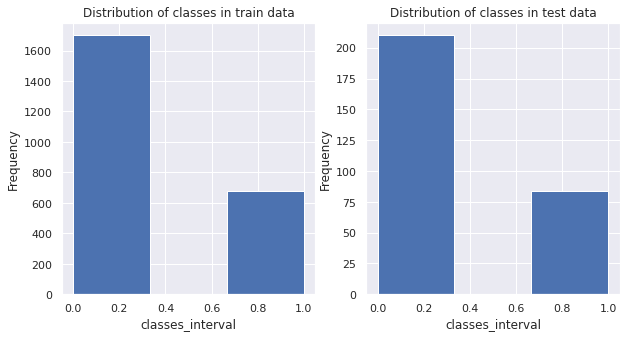

In [110]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Distribution of classes in train data')
plt.xlabel('classes_interval')
plt.ylabel('Frequency')
n,bins,patches = plt.hist(y_train_class,bins=3,edgecolor='white')

plt.subplot(1,2,2)
plt.title('Distribution of classes in test data')
plt.xlabel('classes_interval')
plt.ylabel('Frequency')
plt.hist(y_test_class,bins=3,edgecolor='white')
plt.show() 

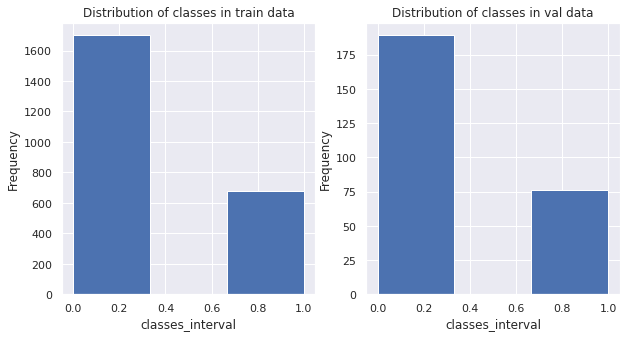

In [111]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Distribution of classes in train data')
plt.xlabel('classes_interval')
plt.ylabel('Frequency')
n,bins,patches = plt.hist(y_train_class,bins=3,edgecolor='white')

plt.subplot(1,2,2)
plt.title('Distribution of classes in val data')
plt.xlabel('classes_interval')
plt.ylabel('Frequency')
plt.hist(y_val_class, bins=3,edgecolor='white')
plt.show()

In [112]:
h, w = 112, 112
transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor()
            ])

In [113]:
print(len(trainlist))
print(len(vallist))
print(len(testlist))

2643
294
294


In [114]:
root = "video/"
train_ds = MortalityData(root, datadict = trainlist, transform= transformer)
val_ds = MortalityData(root, datadict = vallist, transform= transformer)
test_ds = MortalityData(root, datadict = testlist, transform= transformer)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

2643
294
294


In [115]:
idx = 15
imgs, label = train_ds[idx]
print(imgs.shape, label, torch.min(imgs), torch.max(imgs), "\n" , list(trainlist.items())[idx])
imgs,  label = val_ds[idx]
print(imgs.shape, label, torch.min(imgs), torch.max(imgs),"\n" , list(vallist.items())[idx])
imgs,  label = test_ds[idx]
print(imgs.shape, label, torch.min(imgs), torch.max(imgs), "\n" ,list(testlist.items())[idx])

torch.Size([16, 3, 112, 112]) 0 tensor(0.) tensor(0.9961) 
 ('20675812/331ffd7d-89ae-4cfa-977d-fe57d1db0898', {'label': 0})
torch.Size([16, 3, 112, 112]) 0 tensor(0.) tensor(1.) 
 ('20206720/43226ed2-162a-4e2b-9a58-e7719c8f5019', {'label': 0})
torch.Size([16, 3, 112, 112]) 0 tensor(0.) tensor(1.) 
 ('20206720/43226ed2-162a-4e2b-9a58-e7719c8f5019', {'label': 0})


In [116]:
for imgs, label in train_ds:
    print(imgs.shape)
    break

torch.Size([16, 3, 112, 112])


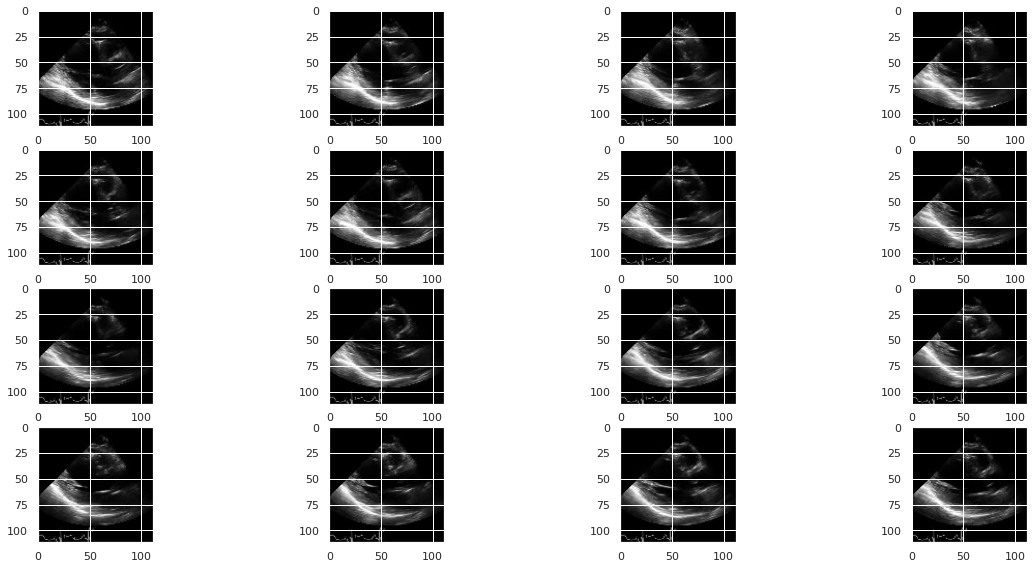

In [117]:
imgs,  label = train_ds[0]
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
count = 0;
for ii,img in enumerate(imgs):
    plt.subplot(8,4,ii+1)
    plt.imshow(to_pil_image(img))

In [118]:
batch_size = 8
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True, collate_fn= collate_fn_r3d_18)
test_dl = DataLoader(test_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_r3d_18)
val_dl = DataLoader(val_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_r3d_18)

In [119]:
for xb, yb in train_dl:
    print(xb.shape, yb.shape)
    break
for xb, yb in val_dl:
    print(xb.shape, yb.shape)
    break
for xb, yb in test_dl:
    print(xb.shape,  yb.shape)
    break

torch.Size([8, 3, 16, 112, 112]) torch.Size([8])
torch.Size([8, 3, 16, 112, 112]) torch.Size([8])
torch.Size([8, 3, 16, 112, 112]) torch.Size([8])


## Model Implementation

In [120]:
resnetmodel = models.video.r2plus1d_18(pretrained=True, progress=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnetmodel = resnetmodel.to(device)
model = MortalityNetVideoClass(resnetmodel)
model = model.to(device)

In [121]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 31,301,151 trainable parameters and total memory usage is 358.2132453918457 mb


## Data Training

### Training

In [85]:
class_weights = class_weight.compute_class_weight('balanced',classes = [0,1],y = X_train_dataframe["mortality"].values)
print(class_weights)

[0.69994703 1.75033113]


In [50]:
opt = optim.AdamW(model.parameters(), lr=0.0005)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.1, patience=10,verbose=1)
loss_func = torch.nn.CrossEntropyLoss(weight = torch.tensor(class_weights).to(device).float())
current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0005


In [ ]:
path2models= "models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 1,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+ "Mackay_mortality_1095days_External_" + datetime.now().strftime('%M_') + "weights.pt",
}

model,loss_hist,metric_hist=train_val(model,params_train)

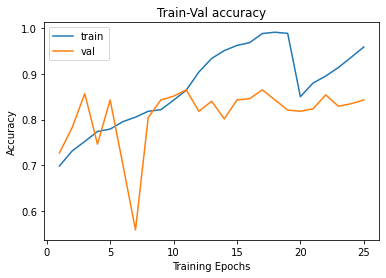

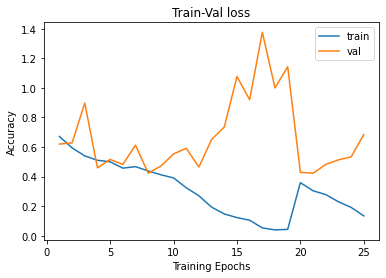

In [53]:

# plot accuracy progress
plt.title("Train-Val accuracy")
plt.plot(range(1,params_train["num_epochs"]+1),metric_hist["train"],label="train")
plt.plot(range(1,params_train["num_epochs"]+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()
    
# plot accuracy progress
plt.title("Train-Val loss")
plt.plot(range(1,params_train["num_epochs"]+1),loss_hist["train"],label="train")
plt.plot(range(1,params_train["num_epochs"]+1),loss_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# 5 fold Cross Validation

### Training 5 fold

In [122]:
Dataframe = pd.read_csv('Generated_csv_files/Mackay_mortality_within_1095_days.csv')
Dataframe = Dataframe.drop(['Unnamed: 0'],axis=1)
Dataframe = Dataframe.sample(frac = 1, random_state=42)
Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)

gender = []
for i in range(len(Dataframe)):
    if(Dataframe['gender'][i]=='Male' or Dataframe['gender'][i]==1):
        gender.append(1)
    else:
        gender.append(0)
Dataframe['gender'] = gender

columns = Dataframe.drop(['PatientID','Mortality_Date', 'CV_death', 'ExamDate', 'A4C_video_id','PLAX_video_id', 'visit_duration', 'visits', 'death_days',
       'mortality'], axis = 1).columns
features = columns

for col in features:
    Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')

Dataframe = Dataframe.replace(r'^\s*$', np.nan, regex=True)
X_data = Dataframe[features]
y_data = Dataframe[['mortality']]

In [123]:
get_features = features
X_data = Dataframe[get_features].values
y_data = Dataframe[['mortality']].values

skf = StratifiedShuffleSplit(test_size=.10, n_splits=5, random_state = 42)
train_inds, test_inds = next(skf.split(X_data, y_data))

X_train_dataframe = Dataframe.iloc[train_inds].reset_index(drop=True)
X_train_data = X_train_dataframe[get_features].values
y_train_data = Dataframe.iloc[train_inds]['mortality'].values

X_test_dataframe = Dataframe.iloc[test_inds].reset_index(drop=True)
X_test = X_test_dataframe[get_features].values
y_test = Dataframe.iloc[test_inds]['mortality'].values
y_test_class = Dataframe.iloc[test_inds]['mortality'].values
X_test_pid = Dataframe.iloc[test_inds]['PatientID'].values


In [124]:
len(X_train_data), len(X_test), len(Dataframe)

(2643, 294, 2937)

In [125]:
h,w = (112,112)
transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor()
            ])

In [ ]:
fold = 5
root = "video/"
count = 1
for train_inds, val_inds in skf.split(X_train_data, y_train_data):
    print("*"*10, "fold " , count, "*"*10)
    X_train_df = X_train_dataframe.iloc[train_inds].reset_index(drop=True)
    X_train = X_train_dataframe.iloc[train_inds][get_features].values
    y_train = X_train_dataframe.iloc[train_inds]['mortality'].values
    X_train_pid = X_train_dataframe.iloc[train_inds]['PatientID'].values

    X_val_df = X_train_dataframe.iloc[val_inds].reset_index(drop=True)
    X_val = X_train_dataframe.iloc[val_inds][get_features].values
    y_val = X_train_dataframe.iloc[val_inds]['mortality'].values
    X_val_pid = X_train_dataframe.iloc[val_inds]['PatientID'].values
    print("the overlapping pids are", len(set(X_train_pid).intersection(set(X_test_pid)).intersection(set(X_val_pid))))
    
    #dataframe definition
    trainlist = {}
    vallist = {}
    testlist = {}
    #sanity check overalaping pid in train and test is
    '''
    print("the overlapping pids are", len(set(X_train_pid).intersection(set(X_test_pid).intersection(X_val_pid))))
    print("dead patients" , len(X_train_dataframe.loc[X_train_dataframe["mortality"]==0]), "alive patients", 
          len(X_train_dataframe.loc[X_train_dataframe["mortality"]==1]))
    print(list(X_train[0]))
    continue
    '''
    
    for i in range(len(X_test_dataframe)):
        testlist[str(X_test_dataframe["PatientID"][i])+"/"+X_test_dataframe["PLAX_video_id"][i]] = {}
        testlist[str(X_test_dataframe["PatientID"][i])+"/"+X_test_dataframe["PLAX_video_id"][i]]["label"] = X_test_dataframe.iloc[i]["mortality"]

    for i in range(len(X_train_df)):
        trainlist[str(X_train_df["PatientID"][i])+"/"+X_train_df["PLAX_video_id"][i]] = {}
        trainlist[str(X_train_df["PatientID"][i])+"/"+X_train_df["PLAX_video_id"][i]]["label"] = X_train_df.iloc[i]["mortality"]

    for i in range(len( X_val_df)):
        vallist[str(X_val_df["PatientID"][i])+"/"+X_val_df["PLAX_video_id"][i]] = {}
        vallist[str(X_val_df["PatientID"][i])+"/"+X_val_df["PLAX_video_id"][i]]["label"] =  X_val_df.iloc[i]["mortality"]

    print(len(X_test), len(X_train), len(X_val), len(X_test) + len(X_train_data), len(Dataframe))
    train_ds = MortalityData(root, datadict = trainlist, transform= transformer)
    val_ds = MortalityData(root, datadict = vallist, transform= transformer)
    test_ds = MortalityData(root, datadict = testlist, transform= transformer)
    batch_size = 8
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_r3d_18)
    val_dl = DataLoader(val_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_r3d_18)
    
    #model definitions
    resnetmodel = models.video.r2plus1d_18(pretrained=True, progress=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    resnetmodel = resnetmodel.to(device)
    model = MortalityNetVideoClass(resnetmodel)
    model = model.to(device)
    
    #training
    class_weights = class_weight.compute_class_weight('balanced',classes = [0,1],y = y_train)
    print(class_weights)
    opt = optim.AdamW(model.parameters(), lr=0.0005)
    lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.1, patience=10,verbose=1)
    loss_func = torch.nn.CrossEntropyLoss(weight = torch.tensor(class_weights).to(device).float())
    current_lr=get_lr(opt)
    print('current lr={}'.format(current_lr))
    
    path2models= "models/"
    if not os.path.exists(path2models):
            os.mkdir(path2models)

    params_train={
        "num_epochs": 25,
        "optimizer": opt,
        "loss_func": loss_func,
        "train_dl": train_dl,
        "val_dl": val_dl,
        "sanity_check": False,
        "lr_scheduler": lr_scheduler,
        "path2weights": path2models+ "fold_1095/Mackay_mortality_1095days_Internal_fold_" + str(count) + "_" + datetime.now().strftime('%M_') + "weights.pt",
    }

    model,loss_hist,metric_hist=train_val(model,params_train)
    
    # plot accuracy progress
    plt.title("Train-Val accuracy")
    plt.plot(range(1,params_train["num_epochs"]+1),metric_hist["train"],label="train")
    plt.plot(range(1,params_train["num_epochs"]+1),metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    # plot accuracy progress
    plt.title("Train-Val loss")
    plt.plot(range(1,params_train["num_epochs"]+1),loss_hist["train"],label="train")
    plt.plot(range(1,params_train["num_epochs"]+1),loss_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()
    print("*"*20)
    count+=1

### Testing 5 fold

In [43]:
Dataframe = pd.read_csv('Generated_csv_files/Mackay_mortality_within_1095_days.csv')
Dataframe = Dataframe.drop(['Unnamed: 0'],axis=1)
Dataframe = Dataframe.sample(frac = 1, random_state=42)
Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)

gender = []
for i in range(len(Dataframe)):
    if(Dataframe['gender'][i]=='Male' or Dataframe['gender'][i]==1):
        gender.append(1)
    else:
        gender.append(0)
Dataframe['gender'] = gender

columns = Dataframe.drop(['PatientID','Mortality_Date', 'CV_death', 'ExamDate', 'A4C_video_id','PLAX_video_id', 'visit_duration', 'visits', 'death_days',
       'mortality'], axis = 1).columns
features = columns

for col in features:
    Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')

Dataframe = Dataframe.replace(r'^\s*$', np.nan, regex=True)
X_data = Dataframe[features]
y_data = Dataframe[['mortality']]

In [44]:
get_features = features
X_data = Dataframe[get_features].values
y_data = Dataframe[['mortality']].values

skf = StratifiedShuffleSplit(test_size=.10, n_splits=5, random_state = 42)
train_inds, test_inds = next(skf.split(X_data, y_data))

X_train_dataframe = Dataframe.iloc[train_inds].reset_index(drop=True)
X_train_data = X_train_dataframe[get_features].values
y_train_data = Dataframe.iloc[train_inds]['mortality'].values

X_test_dataframe = Dataframe.iloc[test_inds].reset_index(drop=True)
X_test = X_test_dataframe[get_features].values
y_test = Dataframe.iloc[test_inds]['mortality'].values
y_test_class = Dataframe.iloc[test_inds]['mortality'].values
X_test_pid = Dataframe.iloc[test_inds]['PatientID'].values


In [45]:
len(X_train_data), len(X_test), len(Dataframe)

(2643, 294, 2937)

In [46]:
h,w = (112,112)
transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor()
            ])

In [47]:
testlist = {}
for i in range(len(X_test_dataframe)):
        testlist[str(X_test_dataframe["PatientID"][i])+"/"+X_test_dataframe["PLAX_video_id"][i]] = {}
        testlist[str(X_test_dataframe["PatientID"][i])+"/"+X_test_dataframe["PLAX_video_id"][i]]["label"] = X_test_dataframe.iloc[i]["mortality"]
batch_size = 8
root = "video/"
test_ds = MortalityData(root, datadict = testlist, transform= transformer)    
test_dl = DataLoader(test_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_r3d_18)

In [48]:
five_fold_results = {}
five_fold_results['Target'] = []
five_fold_results['Fold1'] = []

********** fold  1 **********



  0%|          | 0/331 [00:00<?, ?it/s]


 cut off obtained from Mackay train data 
 
Best YD index : 0.8704912167471097 
best threshold : 0.46789973974227905



  0%|          | 0/37 [00:00<?, ?it/s]

Best YD index : 0.6833333333333333 
best threshold : 0.38887467980384827

 Confusion Matrix with a cutoff of + 0.46789974

              precision    recall  f1-score   support

       Alive       0.91      0.86      0.89       210
        Dead       0.70      0.80      0.74        84

    accuracy                           0.84       294
   macro avg       0.81      0.83      0.82       294
weighted avg       0.85      0.84      0.85       294



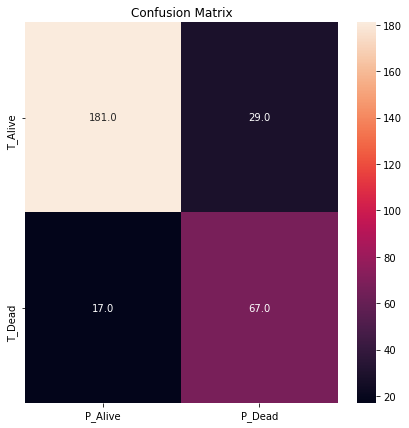

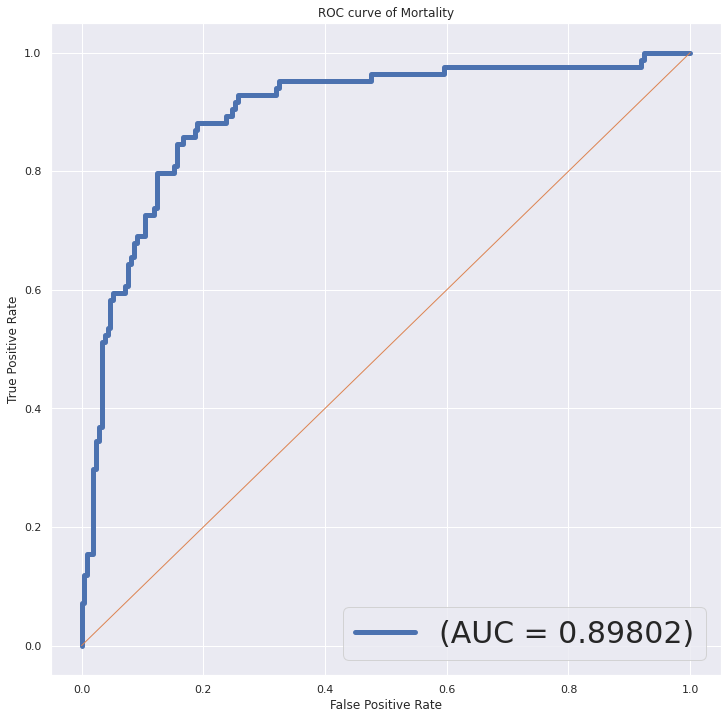

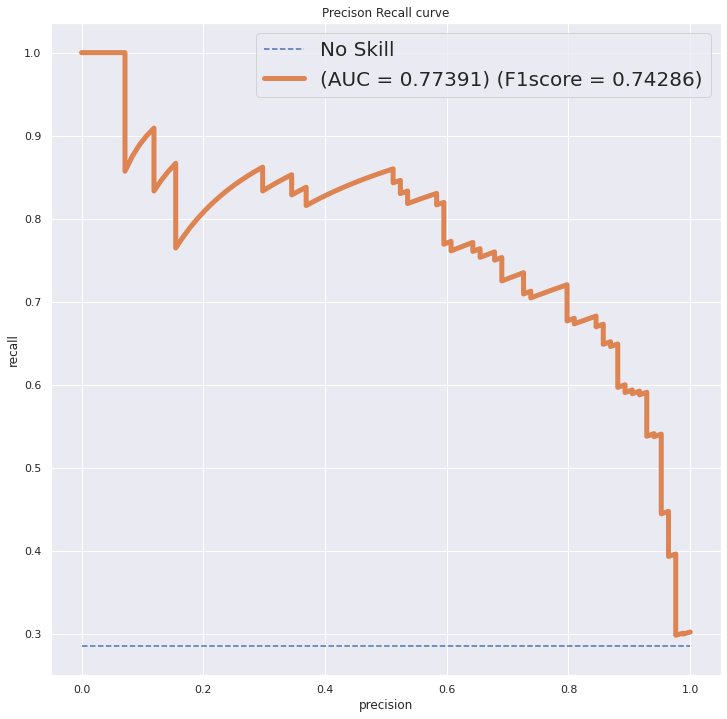

In [49]:
fold = 1
root = "video/"
count = 1

for i in range(5):
    print("*"*10, "fold " , count, "*"*10)
    X_val_df = X_train_dataframe.reset_index(drop=True)
    X_val = X_train_dataframe[get_features].values
    y_val = X_train_dataframe['mortality'].values
    X_val_pid = X_train_dataframe['PatientID'].values
    #print("the overlapping pids are", len(set(X_train_pid).intersection(set(X_test_pid)).intersection(set(X_val_pid))))
    vallist = {}
    
    for i in range(len( X_val_df)):
        vallist[str(X_val_df["PatientID"][i])+"/"+X_val_df["PLAX_video_id"][i]] = {}
        vallist[str(X_val_df["PatientID"][i])+"/"+X_val_df["PLAX_video_id"][i]]["label"] =  X_val_df.iloc[i]["mortality"]
    
    val_ds = MortalityData(root, datadict = vallist, transform= transformer)
    
    batch_size = 8
    
    val_dl = DataLoader(val_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_r3d_18)
    
    #model definitions
    resnetmodel = models.video.r2plus1d_18(pretrained=True, progress=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    resnetmodel = resnetmodel.to(device)
    model = MortalityNetVideoClass(resnetmodel)
    model = model.to(device)
    
    path2models = "models/fold_1095/"
    model.load_state_dict(torch.load(path2models + "Mackay_mortality_1095days_Internal_fold_" + str(count) + "_weights.pt"))
    
    target_eject_val = []
    pred_eject_val = []
    pred_prob_val = []
    softmax = nn.Softmax(dim=0)
    
    model.eval()
    with torch.no_grad():
        print("")
        for xb, yb in tqdm(val_dl):
            xb=xb.to(device)
            yb=yb.to(device)
            output=model(xb)
            for i in range(len(output)):
                pred_eject_val.append(int(torch.argmax(output[i]).item()))
                pred_prob_val.append(np.array(softmax(output[i]).cpu()))
                target_eject_val.append(int(yb[i].item()))
                
    pred_prob_val = np.array(pred_prob_val)
    fpr, tpr,t = get_auc_curve(target_eject_val,pred_prob_val[:, 1])
    print("\n cut off obtained from Mackay train data \n ")
    cutoff = get_best_threshold(target_eject_val, pred_prob_val[:, 1], t)
    
    target_eject = []
    pred_eject = []
    features = []
    pred_prob = []
    softmax = nn.Softmax(dim=0)
    
    model.eval()
    with torch.no_grad():
        print("")
        for xb, yb in tqdm(test_dl):
            xb=xb.to(device)
            yb=yb.to(device)
            output=model(xb)
            for i in range(len(output)):
                pred_eject.append(int(torch.argmax(output[i]).item()))
                pred_prob.append(np.array(softmax(output[i]).cpu()))
                target_eject.append(int(yb[i].item()))
    
    five_fold_results['Target'] = target_eject
    
    class_names=["Alive","Dead"]
    y_test_class_names = get_class_names(target_eject)
    y_test_class = label_binarize(np.array(y_test_class_names),classes=class_names)
    actual_class = target_eject
    pred_class = pred_eject
    #print("\n Confusion Matrix with a cutoff of 0.5 \n ")
    #print_multi_confusion_matrix(actual_class,pred_class,target_names=["Alive","Dead"])
    plt.show()
    
    pred_prob = np.array(pred_prob)
    y_test_class = np.array(y_test_class)
    fpr, tpr,t = get_auc_curve(y_test_class,pred_prob[:, 1])
    get_best_threshold(target_eject, pred_prob[:, 1], t)
    print("\n Confusion Matrix with a cutoff of + " + str(cutoff) + "\n")
    make_confusion_matrix(y_test_class, pred_prob[:, 1],["Alive","Dead"],"Mortality classes",cutoff)
    plt.show()
    
    roc_auc = auc(fpr, tpr)
    fig1 = plt.figure(figsize=[12,12])
    plt.plot(fpr, tpr, lw=5, alpha=1, label='(AUC = %0.5f)' % (roc_auc))
    plt.plot(np.linspace(0,1,len(fpr)), np.linspace(0,1,len(fpr)), lw=1, alpha=1 )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of Mortality')
    plt.legend(loc="lower right",prop={'size': 30})
    
    plt.show()
    
    fig1 = plt.figure(figsize=[12,12])
    F1score = f1_score(actual_class,pred_class)
    precision, recall, thresholds = precision_recall_curve(y_test_class,pred_prob[:, 1])
    auc_score = auc(recall, precision)
    no_skill = len(y_test_class[y_test_class==1]) / len(y_test_class)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision,lw=5, alpha=1, label='(AUC = %0.5f) (F1score = %0.5f)' % (auc_score, F1score))
    
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.title('Precison Recall curve')
    plt.legend(loc="upper right",prop={'size': 20})
    plt.show()
    five_fold_results["Fold"+str(count)] = pred_prob
    count+=1
    break

In [50]:
data = {'Target':five_fold_results['Target'],
       'Prob':five_fold_results['Fold1'][:, 1]}
df = pd.DataFrame(data)

In [51]:
df.to_csv('Generated_csv_files/DL_5fold_1095.csv')

# External Validation on Alberta Dataset

## Getting the cutoff from the mackay Data

In [29]:
#getting the cutoff from the main data
Dataframe = pd.read_csv('Generated_csv_files/Mackay_mortality_within_1095_days.csv')
Dataframe = Dataframe.drop(['Unnamed: 0'],axis=1)
Dataframe = Dataframe.sample(frac = 1, random_state=42)
Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)

gender = []
for i in range(len(Dataframe)):
    if(Dataframe['gender'][i]=='Male' or Dataframe['gender'][i]==1):
        gender.append(1)
    else:
        gender.append(0)
Dataframe['gender'] = gender

columns = Dataframe.drop(['PatientID','Mortality_Date', 'CV_death', 'ExamDate', 'A4C_video_id','PLAX_video_id', 'visit_duration', 'visits', 'death_days',
       'mortality'], axis = 1).columns
features = columns

for col in features:
    Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')

Dataframe = Dataframe.replace(r'^\s*$', np.nan, regex=True)
X_data = Dataframe[features]
y_data = Dataframe[['mortality']]

In [30]:
len(Dataframe.loc[Dataframe['mortality']==1]['PatientID']) , len(Dataframe.loc[Dataframe['mortality']==0])

(839, 2098)

In [31]:
testlist = {}
for i in range(len(Dataframe)):
    testlist[str(Dataframe["PatientID"][i])+"/"+ Dataframe["PLAX_video_id"][i]] = {}
    testlist[str(Dataframe["PatientID"][i])+"/"+ Dataframe["PLAX_video_id"][i]]["label"] =  Dataframe.iloc[i]["mortality"]

In [32]:
h, w = 112, 112
transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor()
            ])
batch_size = 8

path = "video/"
test_ds =  MortalityData(path, datadict = testlist, transform= transformer)
print(len(test_ds))
test_dl = DataLoader(test_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_r3d_18)
for xb, yb in test_dl:
    print(xb.shape, yb.shape)
    break

2937
torch.Size([8, 3, 16, 112, 112]) torch.Size([8])


In [33]:
resnetmodel = models.video.r2plus1d_18(pretrained=True, progress=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnetmodel = resnetmodel.to(device)
model = MortalityNetVideoClass(resnetmodel)
model = model.to(device)

In [34]:
path2models = "models/"
#Mackay_3_class_fold_10_weights.pt
model.load_state_dict(torch.load(path2models + "Mackay_mortality_1095days_External_weights.pt"))

<All keys matched successfully>

In [35]:
target_eject = []
pred_eject = []
features = []
pred_prob = []
softmax = nn.Softmax(dim=0)
model.eval()
with torch.no_grad():
    print("")
    for xb, yb in tqdm(test_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        for i in range(len(output)):
            pred_eject.append(int(torch.argmax(output[i]).item()))
            pred_prob.append(np.array(softmax(output[i]).cpu()))
            target_eject.append(int(yb[i].item()))

  0%|          | 0/368 [00:00<?, ?it/s]

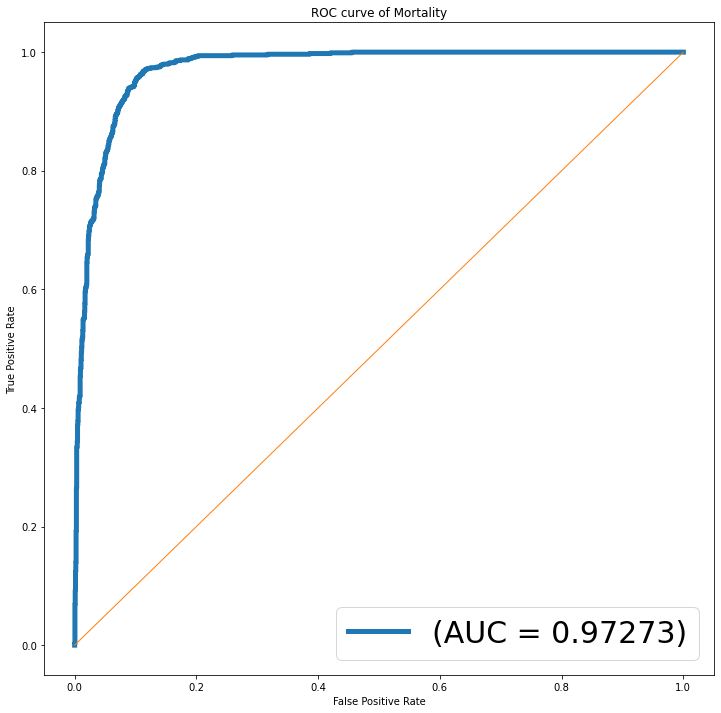

In [36]:
actual_class = target_eject
class_names=["Alive","Dead"]
y_test_class_names = get_class_names(actual_class)
y_test_class = label_binarize(np.array(y_test_class_names),classes=class_names)
pred_prob = np.array(pred_prob)
y_test_class = np.array(y_test_class)
fpr, tpr,t = get_auc_curve(y_test_class,pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
fig1 = plt.figure(figsize=[12,12])
plt.plot(fpr, tpr, lw=5, alpha=1, label='(AUC = %0.5f)' % (roc_auc))
plt.plot(np.linspace(0,1,len(fpr)), np.linspace(0,1,len(fpr)), lw=1, alpha=1 )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Mortality')
plt.legend(loc="lower right",prop={'size': 30})
plt.show()

Best YD index : 0.8546154973634008 
best threshold : 0.5593422055244446
              precision    recall  f1-score   support

       Alive       0.99      0.89      0.93      2098
        Dead       0.78      0.97      0.86       839

    accuracy                           0.91      2937
   macro avg       0.88      0.93      0.90      2937
weighted avg       0.93      0.91      0.91      2937



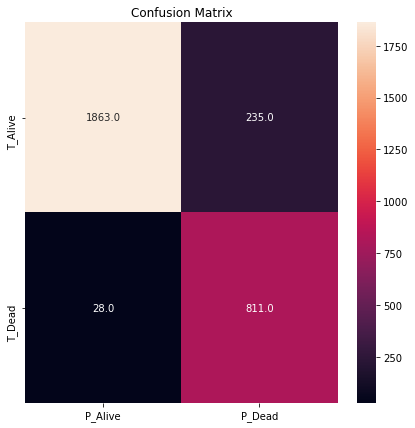

In [37]:
external_cutoff = get_best_threshold(y_test_class, pred_prob[:, 1], t)
make_confusion_matrix(y_test_class, pred_prob[:, 1],["Alive","Dead"],"Mortality classes",external_cutoff)

## Tesing on Alberta

In [29]:
root = "../AlbertaHeart/"
Dataframe = pd.read_csv(root + 'Generated_csv_files/Alberta_mortality_1095_days.csv')
Dataframe = Dataframe.rename(columns={"StudyNumber":"PatientID", "PLAX_video_path":"PLAX_video_id"})
Dataframe = Dataframe.drop(['Unnamed: 0','Obs'],axis=1)
Dataframe = Dataframe.sample(frac = 1, random_state=42)
Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()

In [30]:
len(Dataframe.loc[Dataframe['mortality']==0]),len(Dataframe.loc[Dataframe['mortality']==1])

(534, 61)

In [31]:
gender = []
for i in range(len(Dataframe)):
    if(Dataframe['Gender'][i]=='Male' or Dataframe['Gender'][i]==1):
        gender.append(1)
    else:
        gender.append(0)
Dataframe['Gender'] = gender

columns = Dataframe.drop(['PatientID','fileID','EventName', 'visit_date','death_date','days_to_event', 'days_to_event(all)',
                          'A4C_video_path','PLAX_video_id','mortality'], axis = 1).columns
features = columns

for col in features:
    Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')

Dataframe = Dataframe.replace(r'^\s*$', np.nan, regex=True)
X_data = Dataframe[features].values
y_data = Dataframe[['mortality']].values

In [32]:
len(Dataframe),len(Dataframe['PatientID'].unique())

(595, 595)

In [33]:
len(Dataframe.loc[Dataframe['mortality']==1]['PatientID'].unique()) , len(Dataframe.loc[Dataframe['mortality']==0]),

(61, 534)

In [34]:
testlist = {}
h, w = 112, 112
transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor()
            ])
batch_size = 8
for i in range(len(Dataframe)):
    testlist[Dataframe["fileID"][i] + "/" + Dataframe["PLAX_video_id"][i]] = {}
    testlist[Dataframe["fileID"][i] + "/" + Dataframe["PLAX_video_id"][i]]["label"] = Dataframe.iloc[i]["mortality"]
    testlist[Dataframe["fileID"][i] + "/" + Dataframe["PLAX_video_id"][i]]["features"] = X_data[i]
path = "../AlbertaHeart/video/"
test_ds =  MortalityData(path, datadict = testlist, transform= transformer)
print(len(test_ds))
test_dl = DataLoader(test_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_r3d_18)
for xb, yb in test_dl:
    print(xb.shape, yb.shape)
    break

595
torch.Size([8, 3, 16, 112, 112]) torch.Size([8])


In [35]:
resnetmodel = models.video.r2plus1d_18(pretrained=True, progress=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnetmodel = resnetmodel.to(device)
model = MortalityNetVideoClass(resnetmodel)
model = model.to(device)

In [36]:
path2models = "models/"
#Mackay_3_class_fold_10_weights.pt
model.load_state_dict(torch.load(path2models + "Mackay_mortality_1095days_External_weights.pt"))

<All keys matched successfully>

In [37]:
target_eject = []
pred_eject = []
features = []
pred_prob = []
softmax = nn.Softmax(dim=0)
max_val_True = 0
max_val_False = 0
max_ind_True = 0
max_ind_False = 0
count = 0
model.eval()
with torch.no_grad():
    print("")
    for xb, yb in tqdm(test_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        for i in range(len(output)):
            pred_eject.append(int(torch.argmax(output[i]).item()))
            pred_prob.append(np.array(softmax(output[i]).cpu()))
            target_eject.append(int(yb[i].item()))
            if(pred_prob[-1][1]>=max_val_True and pred_eject[-1]==target_eject[-1]):
                max_val_True = pred_prob[-1][1]
                max_ind_True = (count,i) 
            if(pred_prob[-1][0]>=max_val_False and pred_eject[-1]==target_eject[-1]):
                if(count!=17 and count!=0):
                    max_val_False = pred_prob[-1][0]
                    max_ind_False = (count,i) 
            
        count+=1

  0%|          | 0/75 [00:00<?, ?it/s]

In [39]:
max_ind_True, max_ind_False

((30, 4), (34, 0))

In [41]:
pred_prob = np.array(pred_prob)
data = {'Target':target_eject,
        'Pred':pred_eject,
       'Prob':pred_prob[:, 1]}
df = pd.DataFrame(data)

In [42]:
df.to_csv('Generated_csv_files/DL_1095.csv')

              precision    recall  f1-score   support

       Alive       0.96      0.73      0.83       534
        Dead       0.23      0.72      0.35        61

    accuracy                           0.73       595
   macro avg       0.60      0.72      0.59       595
weighted avg       0.88      0.73      0.78       595



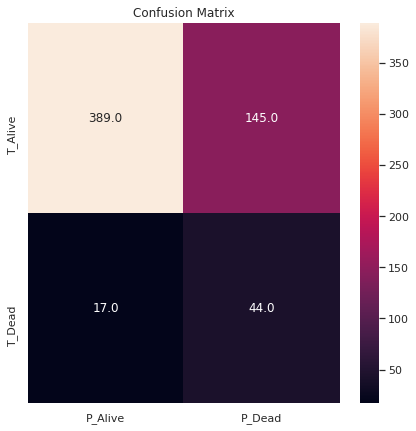

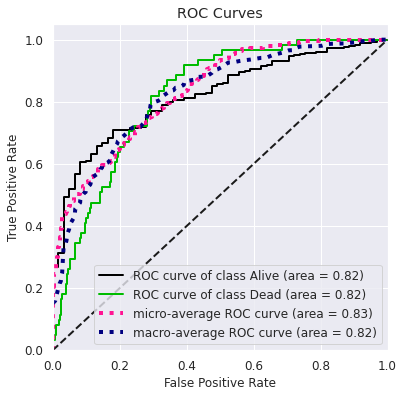

In [50]:
actual_class = target_eject
pred_class = pred_eject
class_names=["Alive","Dead"]
print_multi_confusion_matrix(actual_class,pred_class,target_names=class_names)
y_test_class_names = get_class_names(actual_class)
plot_roc_multi(np.array(y_test_class_names), np.array(pred_prob),class_labels = class_names,figsize=(6,6))
plt.show()

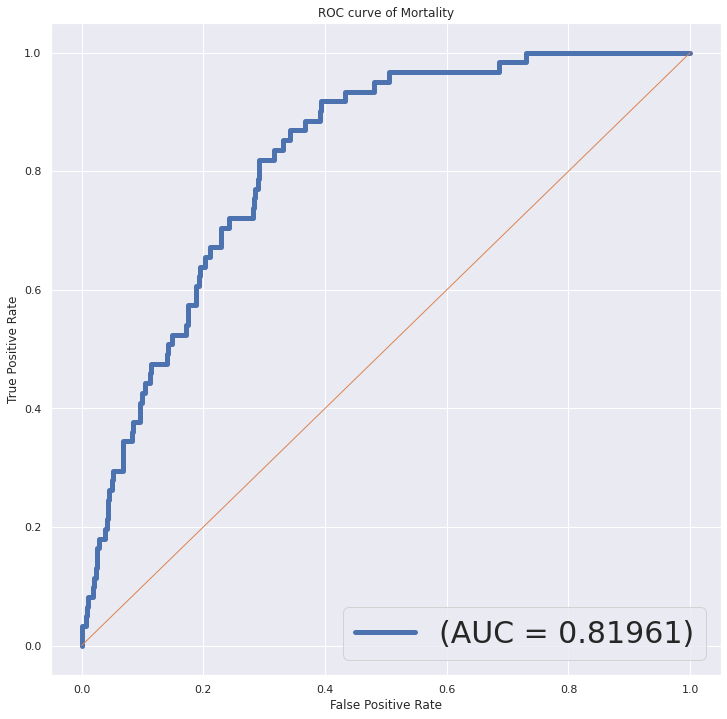

In [51]:
class_names=["Alive","Dead"]
y_test_class_names = get_class_names(actual_class)
y_test_class = label_binarize(np.array(y_test_class_names),classes=class_names)
pred_prob = np.array(pred_prob)
y_test_class = np.array(y_test_class)
fpr, tpr,t = get_auc_curve(y_test_class,pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
fig1 = plt.figure(figsize=[12,12])
plt.plot(fpr, tpr, lw=5, alpha=1, label='(AUC = %0.5f)' % (roc_auc))
plt.plot(np.linspace(0,1,len(fpr)), np.linspace(0,1,len(fpr)), lw=1, alpha=1 )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Mortality')
plt.legend(loc="lower right",prop={'size': 30})
plt.show()

Best YD index : 0.5116350463559893 
best threshold : 0.39836210012435913
the external cutoff from the Mackay is 0.5593422
              precision    recall  f1-score   support

       Alive       0.96      0.75      0.84       534
        Dead       0.25      0.72      0.37        61

    accuracy                           0.75       595
   macro avg       0.60      0.74      0.60       595
weighted avg       0.89      0.75      0.79       595



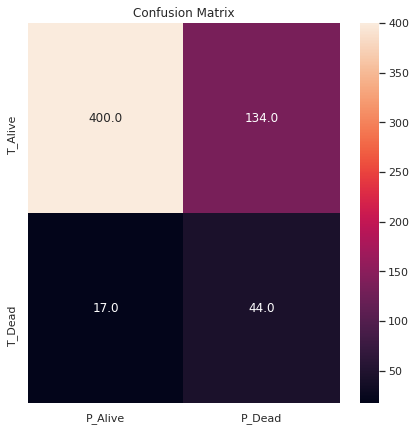

In [52]:
cutoff = get_best_threshold(y_test_class, pred_prob[:, 1], t)
print("the external cutoff from the Mackay is", external_cutoff)
make_confusion_matrix(y_test_class, pred_prob[:, 1],["Alive","Dead"],"Mortality classes",external_cutoff)

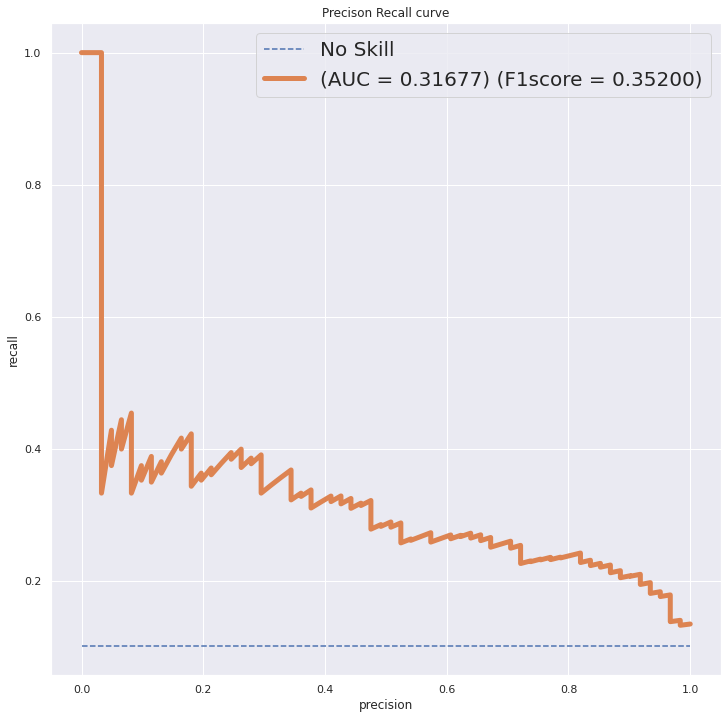

In [44]:

fig1 = plt.figure(figsize=[12,12])
F1score = f1_score(actual_class,pred_class)
precision, recall, thresholds = precision_recall_curve(y_test_class,pred_prob[:, 1])
auc_score = auc(recall, precision)
no_skill = len(y_test_class[y_test_class==1]) / len(y_test_class)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision,lw=5, alpha=1, label='(AUC = %0.5f) (F1score = %0.5f)' % (auc_score, F1score))

plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precison Recall curve')
plt.legend(loc="upper right",prop={'size': 20})
plt.show()

## Activation Maps

In [70]:
len(test_dl)

75

In [71]:
resnetmodel = models.video.r2plus1d_18(pretrained=True, progress=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnetmodel = resnetmodel.to(device)
model = MortalityNetVideoClass(resnetmodel)
model = model.to(device)

In [72]:
path2models = "models/"
#Mackay_3_class_fold_10_weights.pt
model.load_state_dict(torch.load(path2models + "Mackay_mortality_1095days_External_weights.pt"))

<All keys matched successfully>

In [73]:
stop = 34
batch_image = 0
count= 0
for xb, yb in test_dl:
    if(count==stop):
        break
    count+=1
xb_out = xb.to(device)
model.eval()
output = model(xb_out[batch_image].unsqueeze(0))
target = np.argmax(output.cpu().detach().numpy())
one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
one_hot_output[0][target] = 1
print(output , one_hot_output)

tensor([[ 5.2676, -3.4033]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[1., 0.]])


In [74]:
output.backward(gradient = one_hot_output.to(device), retain_graph=True)
gradients = model.get_activations_gradient()

The target moraltiy is  tensor(0, device='cuda:0')
The predicted moraltiy is  tensor([ 5.2676, -3.4033], device='cuda:0')
The activation maps of the 16 frames of the video 
 
The probability of prediction is ,  tensor([9.9983e-01, 1.7147e-04])
torch.Size([1, 512, 2, 7, 7])
torch.Size([512])
torch.Size([1, 512, 2, 7, 7])
torch.Size([2, 7, 7])
torch.Size([16, 3, 112, 112])


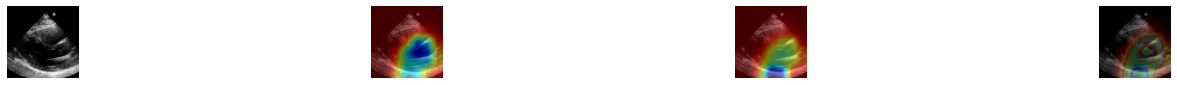

In [75]:
activations = get_activation_maps(model , gradients, xb,  yb, batch_image)

The target moraltiy is  tensor(0, device='cuda:0')
The predicted moraltiy is  tensor([ 5.2676, -3.4033], device='cuda:0')
The activation maps of the 16 frames of the video 
 
The probability of prediction is ,  tensor([9.9983e-01, 1.7147e-04])
torch.Size([1, 512, 2, 7, 7])
torch.Size([512])
torch.Size([1, 512, 2, 7, 7])
torch.Size([7, 7])
torch.Size([16, 3, 112, 112])


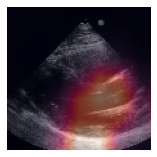

In [76]:
sn.set(font_scale=1) 
get_activation_maps_pooled(model , gradients, xb,  yb, batch_image)